In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# API Authoriazation

In [2]:
import random
import hashlib
import base64
import requests
import urllib

In [3]:
api_base = "https://api.spotify.com/v1"
client_id = "XXXXXXXXX"
scope = "playlist-read-private user-read-private user-read-email playlist-modify-private playlist-modify-public"

Authenticate using authorization flow + pkce

In [ ]:
def createAuthorizedRequestsInstance():
    rand = random.SystemRandom()
    code_verifier = ''.join(rand.choices("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789", k=128))

    code_sha_256 = hashlib.sha256(code_verifier.encode('utf-8')).digest()
    b64 = base64.urlsafe_b64encode(code_sha_256)
    code_challenge = b64.decode('utf-8').replace('=', '')


    oauth_params = {
      "response_type": 'code',
      "client_id": client_id,
      "scope": scope,
      "code_challenge_method": 'S256',
      "code_challenge": code_challenge,
      "redirect_uri": "http://localhost:3000",
    }

    print("https://accounts.spotify.com/authorize?" + urllib.parse.urlencode(oauth_params))
    redirect_with_code = input("paste redirected link here: ")
    response = requests.post(
        "https://accounts.spotify.com/api/token", 
        headers={"Content-Type": "application/x-www-form-urlencoded"},
        data={
            "client_id": client_id,
            "grant_type": 'authorization_code',
            "code": redirect_with_code.split("=")[1],
            "redirect_uri": "http://localhost:3000",
            "code_verifier": code_verifier,
        }
    )
    token_json = response.json()
    if not response.ok:
        raise Error(token_json)
    print(token_json)
    s = requests.Session()
    s.headers.update({'Authorization': 'Bearer ' + token_json["access_token"]})
    return s
s = createAuthorizedRequestsInstance()

# Data Sourcing

In [5]:
plists = {} # [id], name, array of track ids
tracks = {} # [id], name, array of artist ids
track_features = [] # id, ...features
artists = {} # [id], name, array of genres

## Get User ID

In [6]:
user_id = s.get(f"{api_base}/me").json()["id"]

## Get Playlists

In [7]:
def getUserPlaylists():
    json = s.get(f"{api_base}/me/playlists?offset=0&limit=50").json()
    if "error" in json:
        raise Exception(json["error"])
        
    plists = json["items"]
    while json["next"] != None:
        json = s.get(json["next"]).json()
        if "error" in json:
            raise Exception(json["error"])
        plists.extend(json["items"])
    # only want playlists I created
    plists = list(filter(lambda plist: plist["owner"]["id"] == user_id, plists))
    
    # remove all the info we don't need
    return list(map(lambda plist: {"id": plist["id"], "name": plist["name"], "num_tracks": plist["tracks"]["total"]}, plists))

for plist in getUserPlaylists():
    plists[plist["id"]] = plist

In [8]:
for plist_id in plists:
    plist = plists[plist_id]

In [9]:
blacklist_plist_ids = ["3U284JI1xgBsSqYeIOw2f8", "4KhIZeYhVyxIsM9e44FD3X", "48nfAT1zOwtuhf9ZhKBli6", "09MDeW3VDs2ymZIdpfXVnI"]
# plists = list(filter(lambda plist: plist["id"] not in blacklist_plist_ids, plists))
for plist_id in blacklist_plist_ids:
    if plist_id in plists:
        del plists[plist_id]

In [10]:
def getPlaylistTrackIds(plist_id):
    params = urllib.parse.urlencode({"fields": "items(track(id,name,artists)),next"})
    json = s.get(f"{api_base}/playlists/{plist_id}/tracks?{params}").json()
    if "error" in json:
        raise Exception(json["error"])
        
    tracks = json["items"]
    while json["next"] != None:
        json = s.get(json["next"]).json()
        if "error" in json:
            raise Exception(json["error"])
        
        tracks.extend(json["items"])
    # filter out local tracks
    tracks = list(filter(lambda track: track["track"]["id"] != None, tracks))
    return set(map(lambda track: track["track"]["id"], tracks))

In [11]:
all_track_ids = set()
for plist_id in plists:
    plist_tracks = getPlaylistTrackIds(plist_id)
    plists[plist_id]["tracks"] = plist_tracks
    for track_id in plist_tracks:
        all_track_ids.add(track_id)
all_track_ids = list(all_track_ids)

In [12]:
len(all_track_ids)

1042

## Get Track Data

In [13]:
def getTrackMetadata(track_ids):
    # segment it into groups of 100
    if len(track_ids) > 50:
        raise Exception("Too many ids")
    json = s.get(f"{api_base}/tracks?ids="+",".join(track_ids)).json()
    if "error" in json:
        raise Exception(json["error"])
    tracks = []
    for track in json["tracks"]:
        artist_ids = list(map(lambda artist:artist["id"], track["artists"]))
        tracks.append({
            "id": track["id"],
            "name": track["name"],
            "artist_ids": artist_ids
        })
    return tracks

In [14]:
def getTrackFeatures(track_ids):
    if len(track_ids) > 100:
        raise Exception("Too many ids")
    json = s.get(f"{api_base}/audio-features?ids="+",".join(track_ids)).json()
    return json["audio_features"]

In [15]:
all_artist_ids = set()
for i in range(0, len(all_track_ids), 50):
    new_tracks = getTrackMetadata(all_track_ids[i:i+50])
    for track in new_tracks:
        all_artist_ids.update(track["artist_ids"])
        tracks[track["id"]] = track
all_artist_ids = list(all_artist_ids)

In [16]:
for i in range(0, len(all_track_ids), 100):
    track_features.extend(getTrackFeatures(all_track_ids[i:i+100]))

## Get Artist Genres

In [17]:
def getArtistData(artist_ids):
    if len(artist_ids) > 50:
        raise Exception("Too many ids")
    json = s.get(f"{api_base}/artists?ids=" + ",".join(artist_ids)).json()
    if "error" in json:
        raise Exception(json["error"])
    return list(map(lambda artist: {
        "id": artist["id"],
        "name": artist["name"],
        "genres": artist["genres"]
    }, json["artists"]))

In [18]:
for i in range(0, len(all_artist_ids), 50):
    for artist in getArtistData(all_artist_ids[i:i+50]):
        artists[artist["id"]] = artist
        

# Data Validation
only tabular data we have is the track_features

In [19]:
songs_df = pd.DataFrame(track_features)

In [20]:
songs_df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [21]:
songs_df.shape

(1042, 18)

In [22]:
songs_df.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
dtype: object

In [23]:
songs_df.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

In [24]:
songs_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.604,0.950,2,-2.961,0,0.0743,0.0157,0.842000,0.2810,0.688,140.068,audio_features,4p3GL0RZ8HjW7VbAjjayKL,spotify:track:4p3GL0RZ8HjW7VbAjjayKL,https://api.spotify.com/v1/tracks/4p3GL0RZ8HjW...,https://api.spotify.com/v1/audio-analysis/4p3G...,148746,4
1,0.833,0.498,10,-5.196,0,0.1170,0.0493,0.000000,0.1190,0.259,139.928,audio_features,3yaYgjEFkRw3PVjW9mV1TO,spotify:track:3yaYgjEFkRw3PVjW9mV1TO,https://api.spotify.com/v1/tracks/3yaYgjEFkRw3...,https://api.spotify.com/v1/audio-analysis/3yaY...,153406,4
2,0.481,0.179,3,-21.424,1,0.1090,0.6130,0.000028,0.1450,0.405,74.850,audio_features,6LteLVcW0oWLjuW6nePyWb,spotify:track:6LteLVcW0oWLjuW6nePyWb,https://api.spotify.com/v1/tracks/6LteLVcW0oWL...,https://api.spotify.com/v1/audio-analysis/6Lte...,187195,4
3,0.679,0.480,0,-8.548,1,0.0775,0.6400,0.000000,0.0315,0.837,155.014,audio_features,4WwziJRU6hAdI4j8C0j0QI,spotify:track:4WwziJRU6hAdI4j8C0j0QI,https://api.spotify.com/v1/tracks/4WwziJRU6hAd...,https://api.spotify.com/v1/audio-analysis/4Wwz...,280357,4
4,0.707,0.503,0,-11.281,1,0.0358,0.4410,0.000099,0.1600,0.556,148.021,audio_features,5B7K0zs5gkaueWXzgd0vk7,spotify:track:5B7K0zs5gkaueWXzgd0vk7,https://api.spotify.com/v1/tracks/5B7K0zs5gkau...,https://api.spotify.com/v1/audio-analysis/5B7K...,240000,4


In [25]:
songs_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000
mean,0.696362,0.665161,5.196737,-6.698012,0.576775,0.127018,0.236560,0.099045,0.171407,0.520986,125.452464,186473.250480,3.978887
std,0.139818,0.174604,3.732490,3.247306,0.494308,0.104222,0.244338,0.255955,0.124702,0.231812,31.427208,54280.920687,0.293273
min,0.000000,0.002560,0.000000,-30.251000,0.000000,0.000000,0.000005,0.000000,0.022900,0.000000,0.000000,38321.000000,0.000000
25%,0.608250,0.551000,1.000000,-7.962750,0.000000,0.046325,0.044325,0.000000,0.092600,0.341250,99.964000,148184.250000,4.000000
50%,0.714000,0.682000,5.000000,-6.078000,1.000000,0.082200,0.148500,0.000000,0.120000,0.517500,126.374500,187769.000000,4.000000
75%,0.792000,0.795000,8.000000,-4.614500,1.000000,0.194500,0.360750,0.000909,0.221750,0.700000,149.979000,220487.750000,4.000000
max,0.965000,0.993000,11.000000,1.585000,1.000000,0.593000,0.990000,0.970000,0.916000,0.979000,218.709000,410964.000000,5.000000


# Data Visualization

In [26]:
import seaborn as sns

## Playlist Analysis

In [27]:
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'highlight']

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

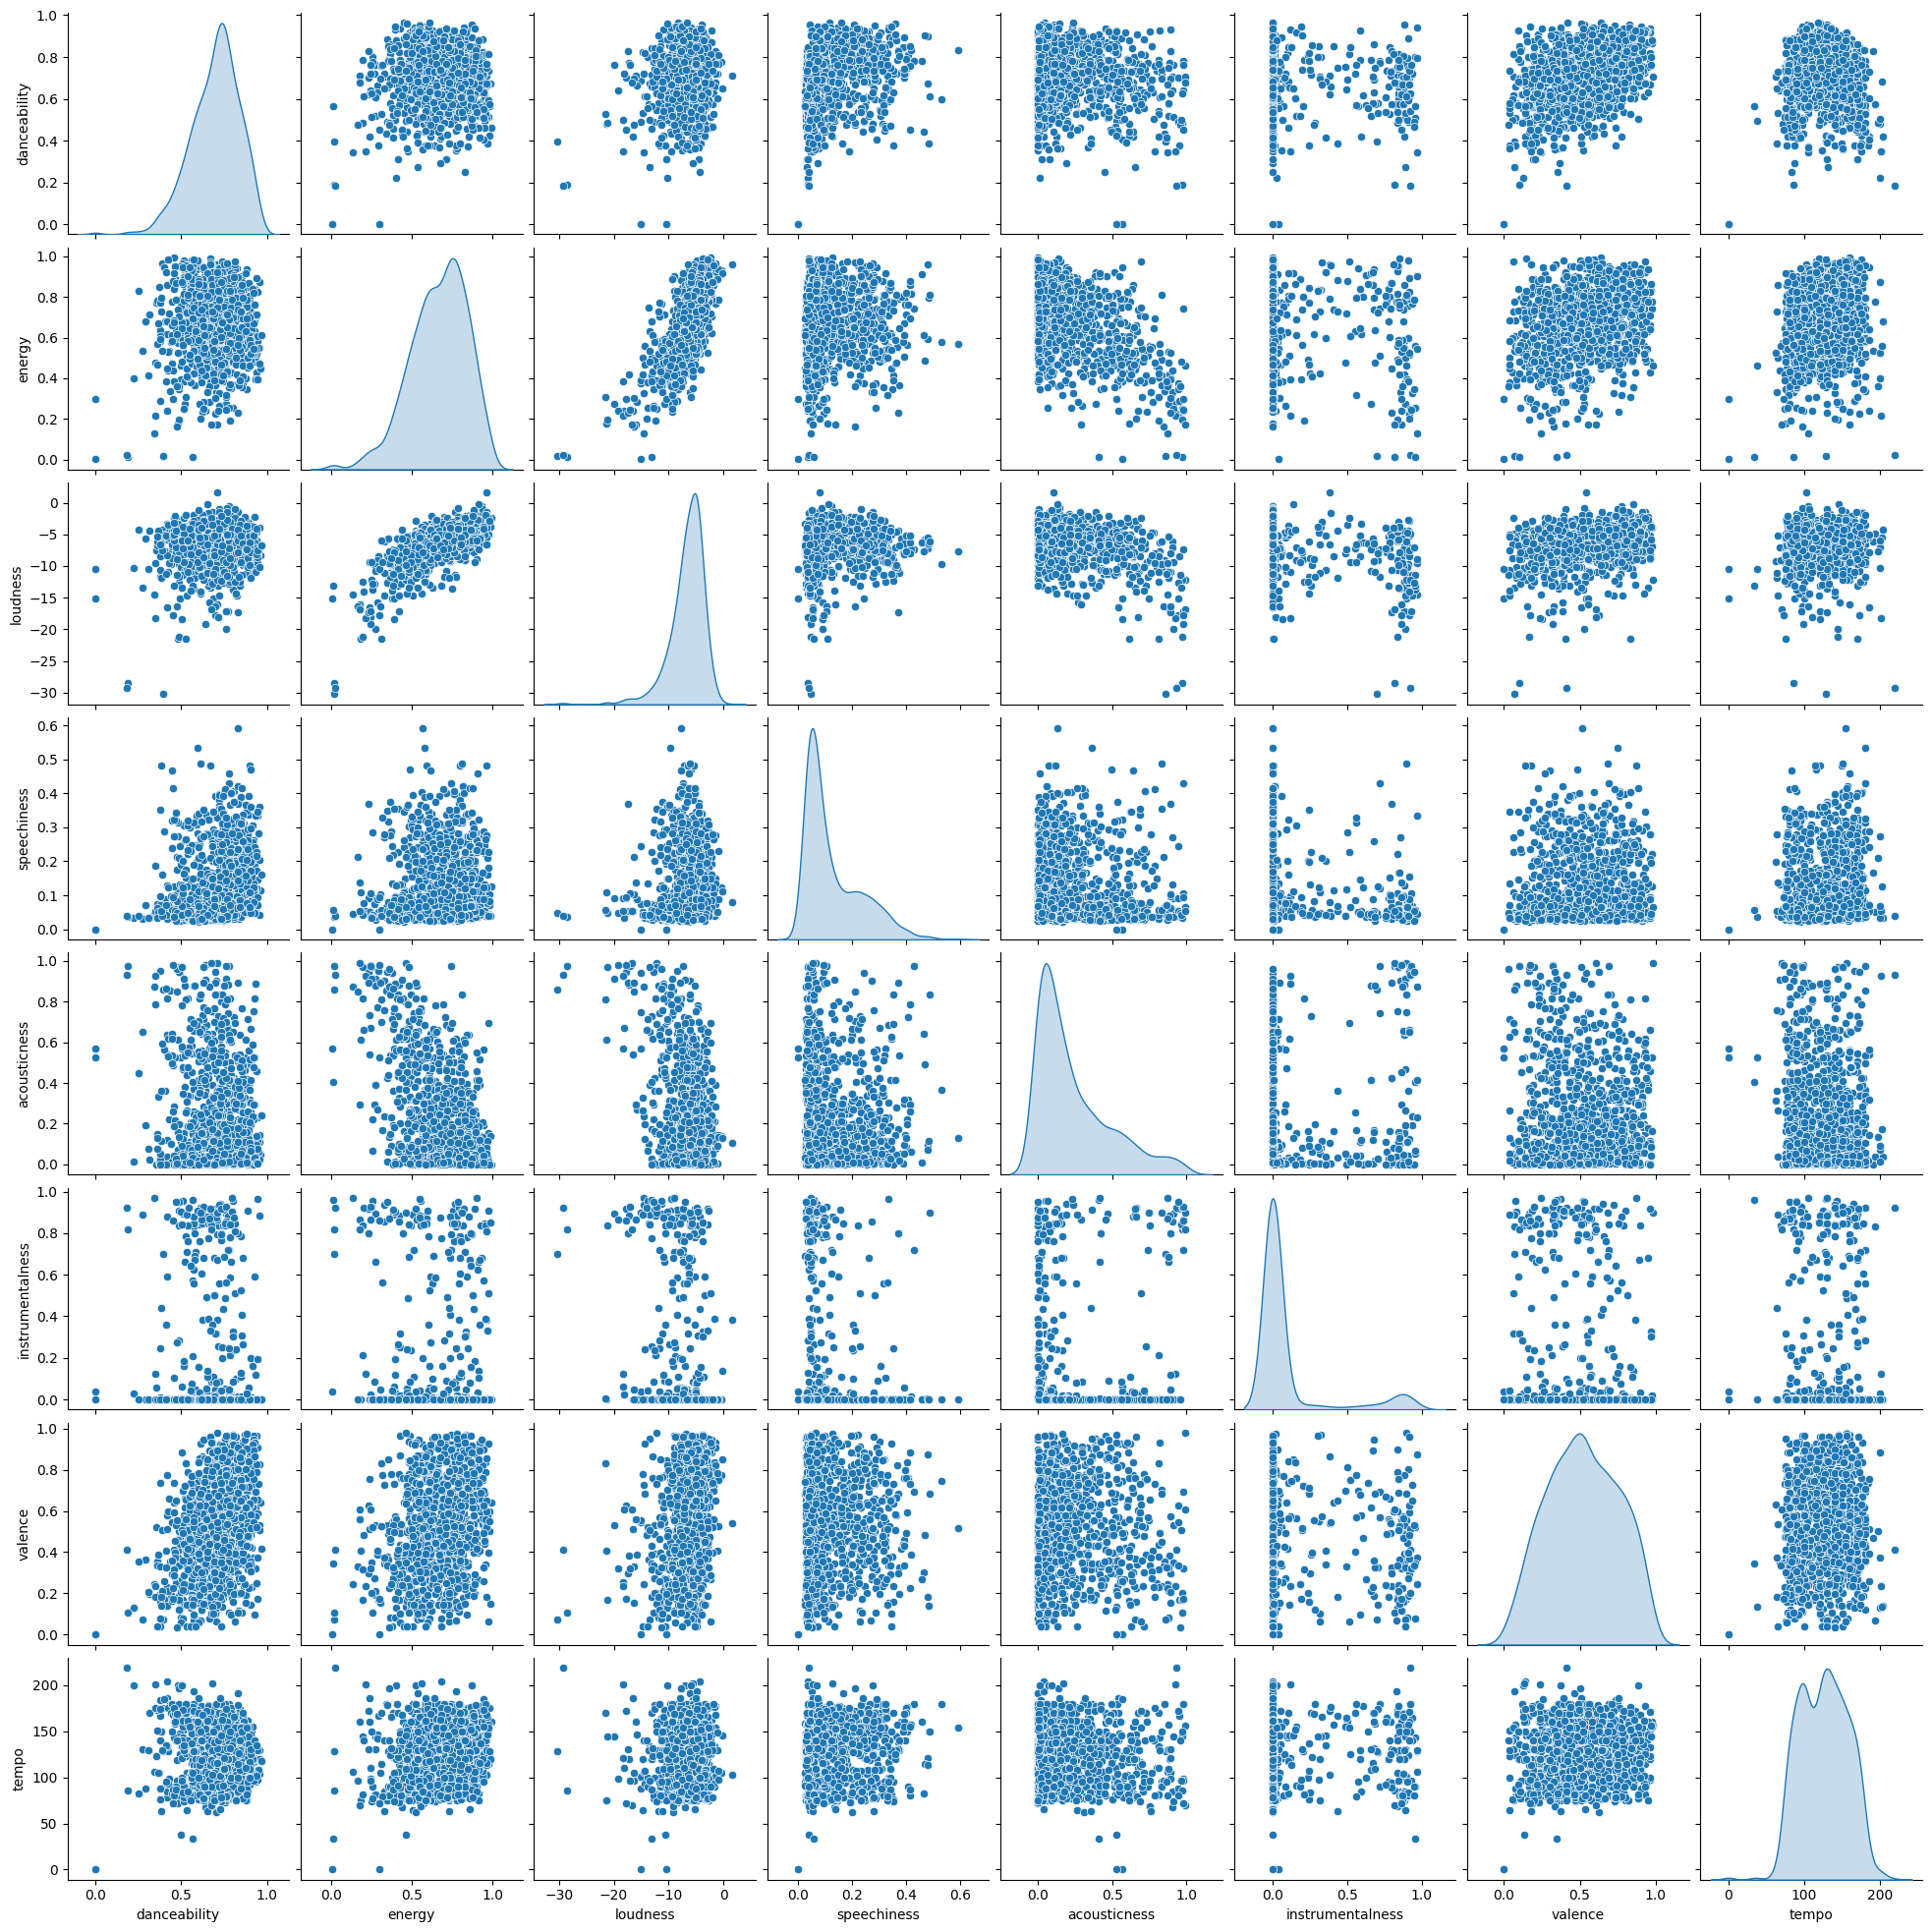

In [28]:
sns.pairplot(songs_df[features[:-1]], diag_kind="kde")

In [29]:
interesting_plists = [
    "1DF3jJc1WGNXOLnXlTYBvG",
    "3fzbjgHahvJALA700pBQSe",
    "62BooR9b0wP07lns5vigHg"
]
def getPlistNumber(track_id):
    for i in range(len(interesting_plists)):
        plist_id = interesting_plists[i]
        if track_id in plists[plist_id]["tracks"]:
            return plist_id
    return ""

These 3 playlists are "vibing", "chilling", and "waiting". Vibing generally had songs I considered to be relatively high in energy, chilling had songs you could kick back and relax to while still wanting to feel good, and sulking had songs I'd want to listen to while I was sad.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

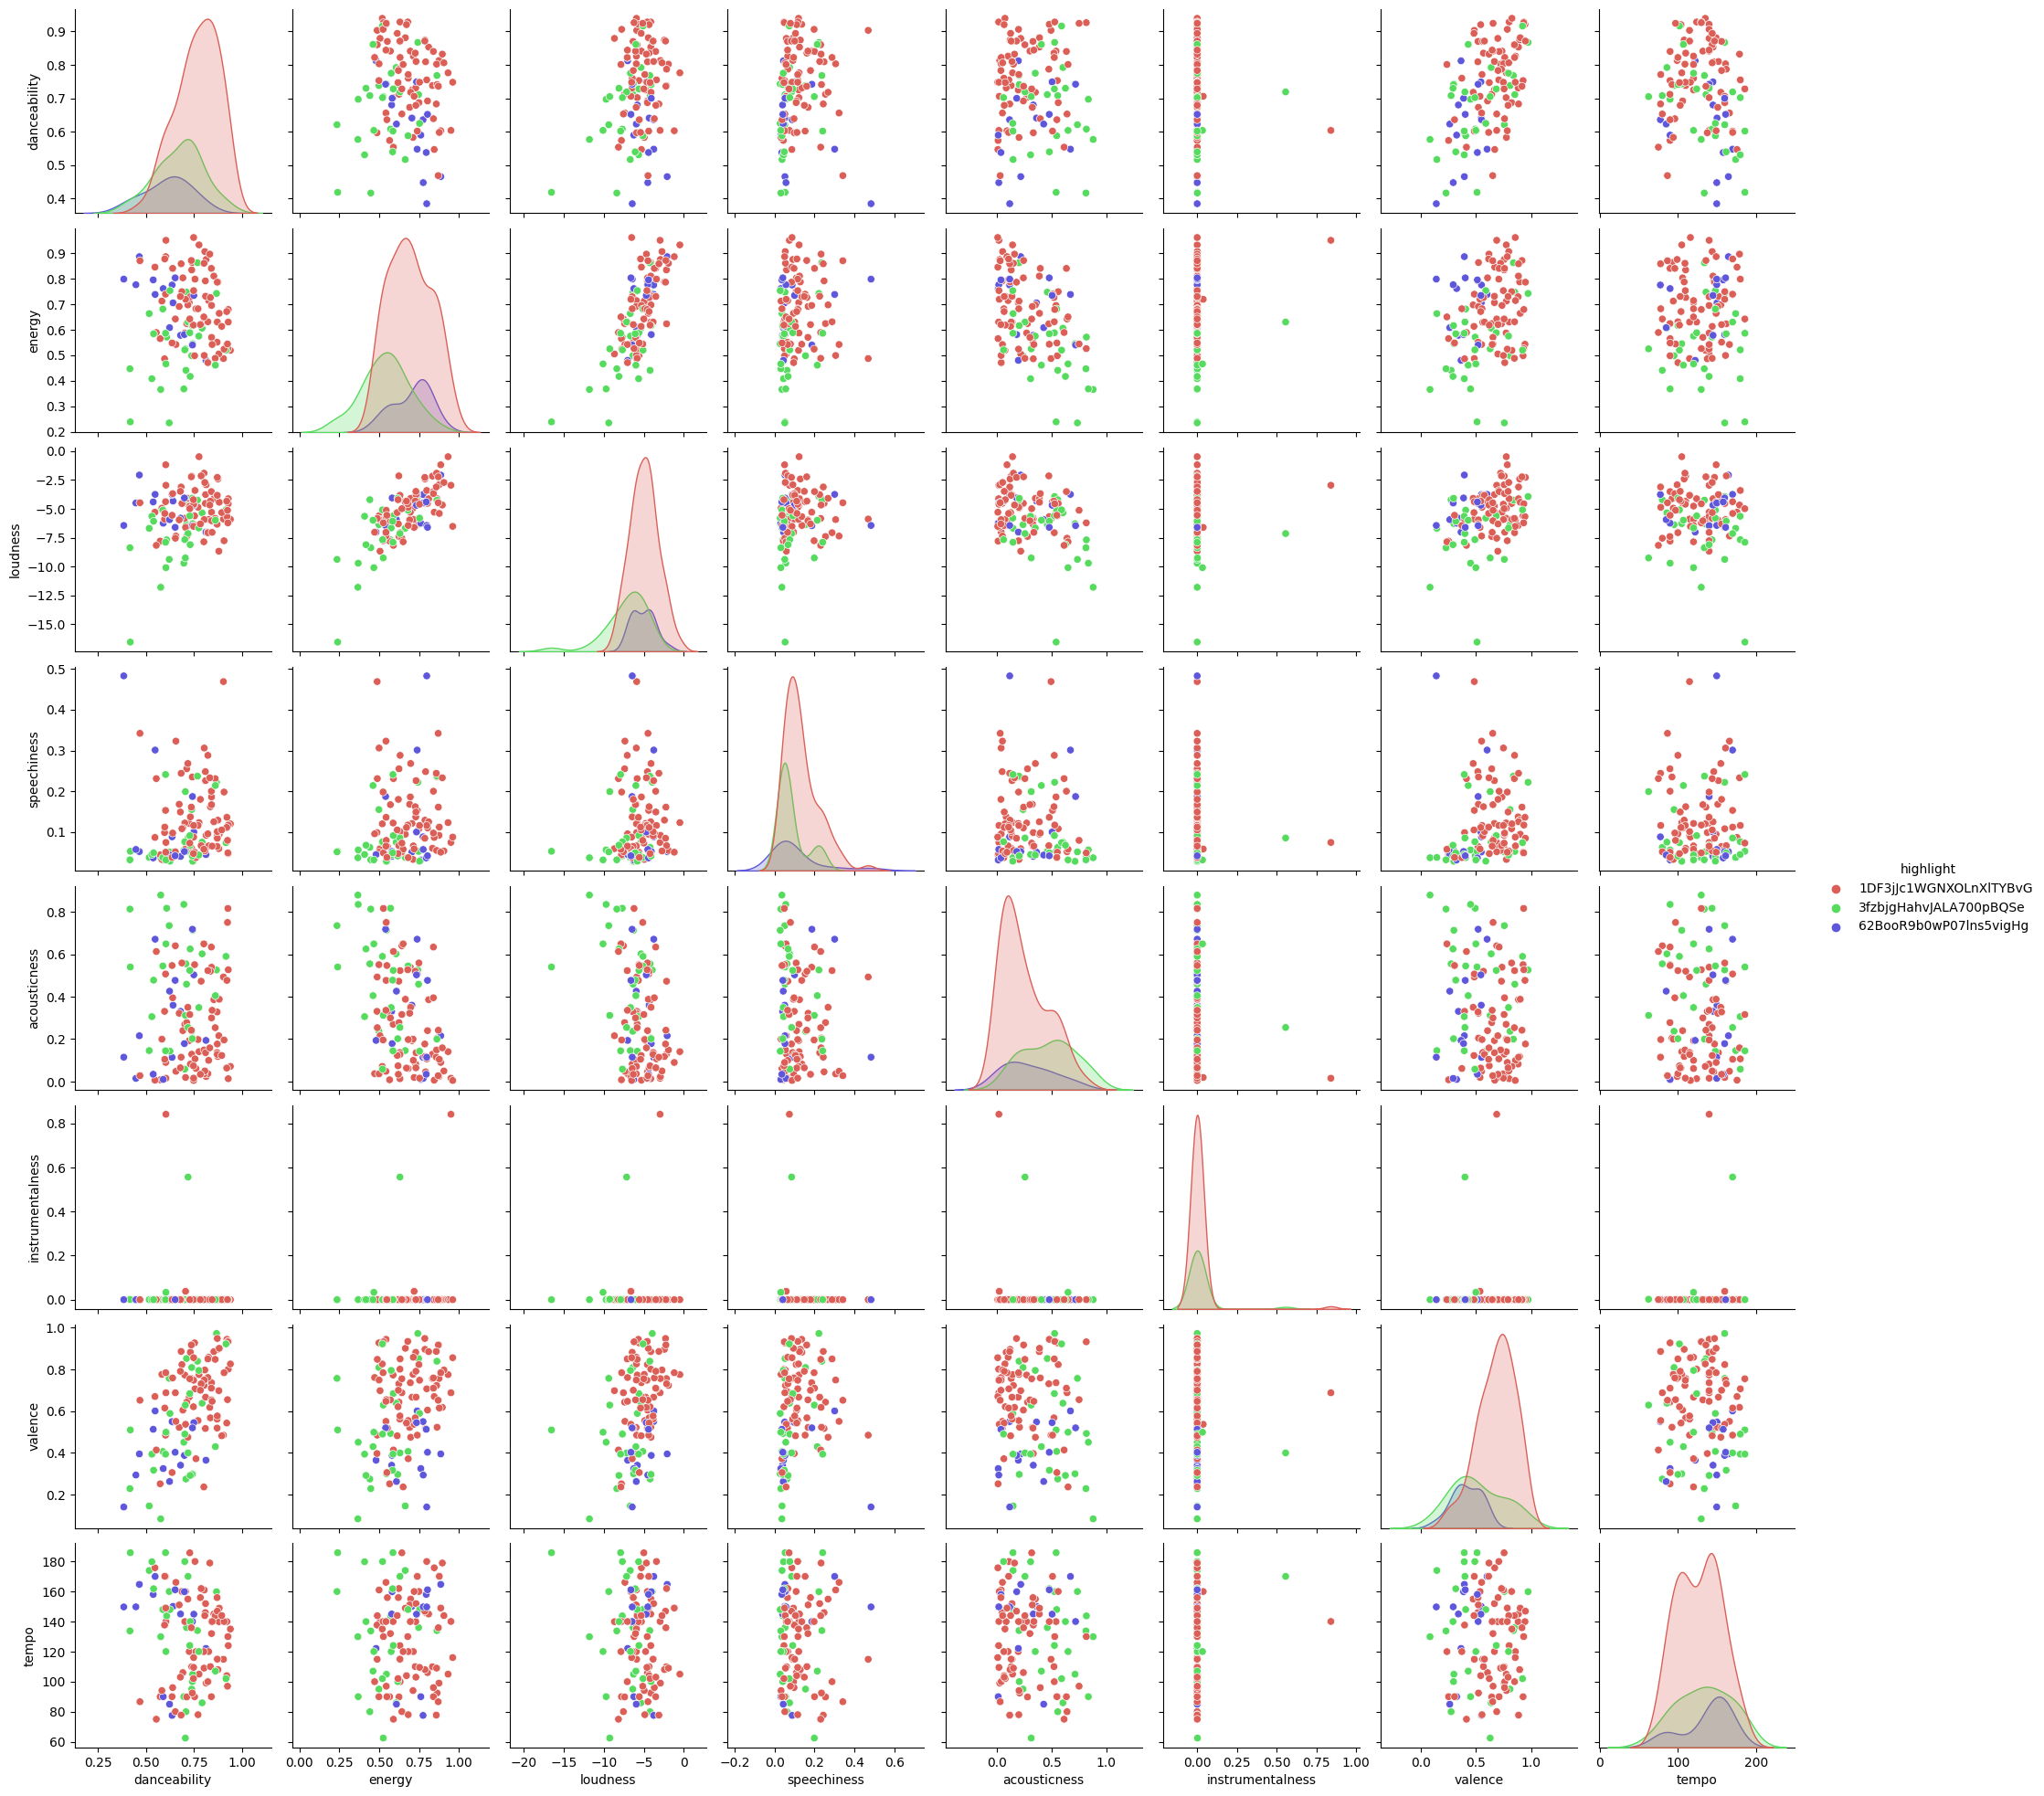

In [30]:
plot_df = songs_df
plot_df["highlight"] = songs_df["id"].map(getPlistNumber)
plot_df.head()
sns.pairplot(plot_df.loc[plot_df["highlight"] != "", features], hue="highlight", palette="hls")

- overall, songs in "chilling" seem to be spread out pretty evenly
- there is signs of seperation in valence between "vibing" and "waiting", also in danceability

In [31]:
for col in features[:-1]:
    print(col)
    print(plot_df.groupby('highlight').describe()[col])

danceability
                        count      mean       std    min     25%     50%  \
highlight                                                                  
                        924.0  0.692738  0.140971  0.000  0.6060  0.7100   
1DF3jJc1WGNXOLnXlTYBvG   74.0  0.767014  0.110347  0.469  0.6945  0.7795   
3fzbjgHahvJALA700pBQSe   29.0  0.674138  0.122554  0.417  0.6020  0.7050   
62BooR9b0wP07lns5vigHg   15.0  0.614000  0.119795  0.385  0.5430  0.6360   

                            75%    max  
highlight                               
                        0.78625  0.965  
1DF3jJc1WGNXOLnXlTYBvG  0.85075  0.939  
3fzbjgHahvJALA700pBQSe  0.74100  0.916  
62BooR9b0wP07lns5vigHg  0.69000  0.812  
energy
                        count      mean       std      min     25%     50%  \
highlight                                                                    
                        924.0  0.666163  0.177537  0.00256  0.5535  0.6875   
1DF3jJc1WGNXOLnXlTYBvG   74.0  0.693838  0.

# Cluster Analysis

In [32]:
training_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']

In [33]:
x = songs_df[training_features] 

In [34]:
from sklearn import preprocessing
x_scaled = preprocessing.scale(x)

In [35]:
from sklearn.manifold import TSNE
X_tsne = TSNE(learning_rate=100).fit_transform(x_scaled)

In [36]:
data = pd.DataFrame({'d1': X_tsne[:, 0], 'd2': X_tsne[:, 1]})
songs_df = songs_df.join(data)

<Axes: xlabel='d1', ylabel='d2'>

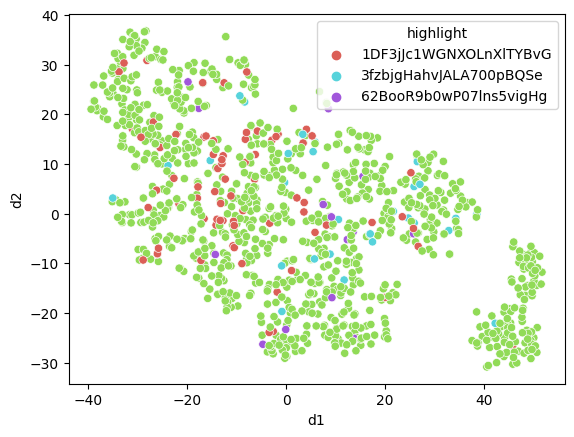

In [37]:
sns.scatterplot(songs_df, x="d1", y="d2", hue="highlight", palette="hls")

Again, we see no clear distinction between playlist songs :(

In [38]:
from sklearn.cluster import KMeans

wcss = []

for i in range(1,11):
    kmeans = KMeans(i)
    kmeans.fit(x_scaled)
    wcss.append(kmeans.inertia_)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

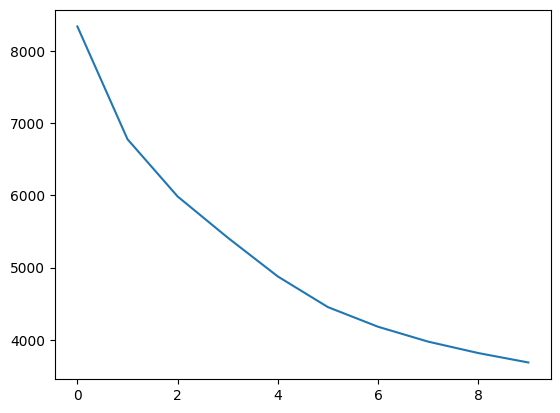

In [39]:
sns.lineplot(wcss)

Would normally use 5 clusters here, but since I want finer results, I'll try 10.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='d1', ylabel='d2'>

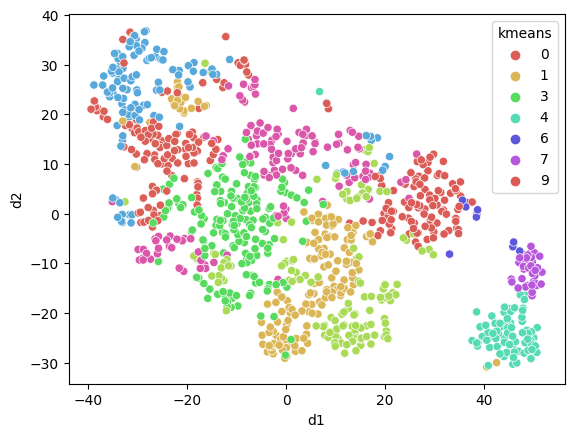

In [40]:
kmeans_model = KMeans(10)
kmeans_model.fit(x_scaled)
data['kmeans'] = kmeans_model.fit_predict(x_scaled)

sns.scatterplot(data=data, x='d1', y='d2', hue='kmeans', palette='hls')

<Axes: xlabel='d1', ylabel='d2'>

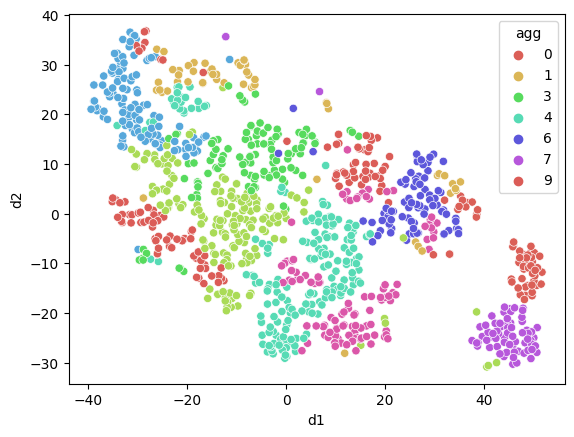

In [41]:
from sklearn.cluster import AgglomerativeClustering

# agglomerative
model_agg = AgglomerativeClustering(n_clusters=10)
model_agg.fit(x_scaled)
data['agg'] = model_agg.fit_predict(x_scaled)

# plotting
sns.scatterplot(data=data, x='d1', y='d2', hue='agg', palette='hls')

In [42]:
clustered = x.join(data)

In [43]:
clustered[training_features + ["agg"]].groupby("agg").mean()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
agg,,,,,,,,
0,0.570093,0.321316,-15.012037,0.072517,0.680915,0.659185,0.337833,106.051537
1,0.671074,0.631333,-7.130444,0.290126,0.395336,0.022858,0.476219,100.171704
2,0.720054,0.811976,-4.135186,0.105619,0.169427,0.028721,0.720790,117.428713
3,0.810847,0.627126,-6.986919,0.099744,0.257917,0.005197,0.779793,122.992757
4,0.598652,0.744928,-5.577061,0.099993,0.157838,0.008648,0.464613,157.049713
5,0.809613,0.679360,-6.435892,0.297604,0.141961,0.004243,0.557352,149.223189
6,0.635696,0.470722,-8.357734,0.060052,0.621823,0.006359,0.412800,120.697468
7,0.679113,0.763507,-6.787606,0.091170,0.121087,0.781127,0.490430,138.753423
8,0.591835,0.657689,-6.569854,0.054400,0.119487,0.010789,0.304925,102.013000


In [44]:
clustered[training_features + ["kmeans"]].groupby("kmeans").mean()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
kmeans,,,,,,,,
0,0.787384,0.765368,-4.931920,0.265224,0.225659,0.021466,0.698568,131.300752
1,0.568809,0.748809,-5.487789,0.100345,0.144819,0.016386,0.447342,160.988092
2,0.614575,0.678291,-6.423984,0.068506,0.115777,0.014891,0.317963,99.907394
3,0.741280,0.802863,-4.285375,0.078568,0.169190,0.013953,0.733571,120.851756
4,0.680635,0.755527,-6.897811,0.082205,0.095920,0.775919,0.483345,136.886311
5,0.776798,0.615092,-7.443817,0.291387,0.153651,0.010294,0.377146,132.480569
6,0.333500,0.170197,-20.602083,0.062092,0.760250,0.292289,0.277100,118.846167
7,0.634091,0.348779,-13.476879,0.073106,0.697703,0.870970,0.362664,105.779121
8,0.806593,0.570279,-7.536929,0.090754,0.235699,0.014042,0.673693,112.037550


In [45]:
clustered = clustered.join(songs_df["id"])

In [46]:
def createClusterPlaylists(clustered, num_clusters):
    for algo in ["agg", "kmeans"]:
        for i in range(num_clusters):
            resp = s.post(f"{api_base}/users/{user_id}/playlists", 
                   headers={"content-type": "application/json"},
                   json={"name": f"{algo} {i}", "public": "false"}
                  )
            if not resp.ok:
                raise Exception(resp.json())
            new_plist_id = resp.json()["id"]

            new_plist_tracks = list(clustered.loc[clustered[algo] == i, "id"])

            for j in range(0, len(new_plist_tracks), 100):
                resp = s.post(
                    f"{api_base}/playlists/{new_plist_id}/tracks",
                    headers={"content-type": "application/json"},
                    json={
                        "uris": list(map(lambda track_id: f"spotify:track:{track_id}", new_plist_tracks[j:j+100]))
                    }
                )
                if not resp.ok:
                    raise Exception(resp.json())

In [47]:
# createClusterPlaylists(clustered, 10)

# Final Thoughts
Both algorithms created a very good lofi/intrumental playlist for me, so in the end, this was worth it. This is probably because this was the easiest to seperate. I also enjoyed listening to the clusters that had high energy, or high danceability, like agg 2, 3, 5, kmeans 8.  
In the end, I do still have some takeaways. I did used to have a hard time quantifying what song would go into what playlists, I used to just go off the _vibe_. From spending some time to look at the data assicoaited with some of these songs, I believe can have a more systematic approach to organize my playlists.